<a id="1"></a>
# <p style="background-color:#000000;font-family:georgia,serif;color:#FFF8ED;font-size:140%;text-align:center;border-radius:10px 10px;">Project Forward</p>

___

<div style="text-align: center;">
  <img src="https://github.com/WillyWill143/Compute-Similarity-App/blob/main/brain_image.jpg?raw=true" alt="brain" width="500">
</div>

___

# About the Notebook:
The goal of this notebook is to build a system that takes two images of faces as input and outputs a percentage of the similarity between their faces, i use the LFW image dataset to test this system and further fine-tune it in the future.

This Project started as a fun challenge between me and my family when i said that my grandma looks like "Angela Merkel" the former chancellor of Germany, we had a team that agrees and a team that doesn't, so it sparked the idea of creating such a project to see what mathematics thinks of the issue!

*Steps Taken:*
1. Data Parsing
2. Preprocessing
3. Feature Extraction using FaceNet
4. Computing similarity using Cosine Similarity.
5. (Not in Notebook) Deployment with Flask (You can find the Flask code [here](https://github.com/WillyWill143/Compute-Similarity-App) ).

Details are provided for every step.

## Step 1:
first dfined helper functions to parse metadata from the lfw dataset. These functions map person names to their corresponding image paths, its used for the lfw dataset so it's not used in deployment.

## Step 2:
It's a class that reads images and uses MTCNN for face detection and alignment, then it resizes the image to (224 by 224) and normalizes pixel values to (0,1) range.

## Step 3:
As i started this project and i experimented with a different pretrained model (ResNet), the one that performed better is FaceNet, mostly it's obvious because it is trained on faces (i didn't have this intuition when i first tried lol), so why FaceNet worked? that's an answer from GPT "FaceNet is a specialized model for face recognition that maps images to a 512-dimensional embedding space. It is designed so that embeddings of the same person are close together while embeddings of different people are far apart."
So the Feature Extraction class uses the FaceNet model (InceptionResnetV1 from the facenet-pytorch library) to generate embeddings.
the code includes a transformation that converts the preprocessed image to the expected format (resizing to 160×160, converting to tensor, and normalizing to the range [-1, 1]). The resizing happens twice you can guess because the preprocessing code was made for ResNet then i moved to FaceNet, i didn't change the code cuz it performed well and there wasn't a need, i will change it later!
and The model outputs a 512-dimensional feature vector for each image.

## Step 4:
Why Cosine Similarity?
Cosine similarity is a measure of the angle between two vectors. When embeddings are L2-normalized (as is standard with FaceNet), cosine similarity is particularly effective:
A value close to 1 indicates very similar (or nearly identical) embeddings.
A lower value indicates dissimilar faces.

<div style="text-align: center;">
  <img src="https://github.com/WillyWill143/Compute-Similarity-App/blob/main/cosine-similarity-formula-equivalent.png?raw=true" alt="formula" width="500">
</div>

The code does L2-normalize the feature vectors.
Calculate cosine similarity between two embeddings.
Convert the cosine similarity to a percentage (by clamping the value between 0 and 1 and multiplying by 100).
___
*Note:* if you have any insight or advice regarding the code, how to make it better and how tomake the system better please feel free to share, and if you know how to make the Flask app look better using HTML and CSS also feel free to provide your edits and i'll add them, i am still new to Flask!

## Installations and Imports

In [1]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.4 MB/s eta 0:00:00:00:01


In [2]:
!pip install torch==1.11.0 torchvision==0.12.0 facenet-pytorch==2.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 932.9 kB/s eta 0:00:000:0100:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.8 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.14.0 requires torch>=1.13.0, but you have torch 1.11.0 which is incompatible.
pytorch-lightning 2.5.0.post0 requires torch>=2.1.0, but you have torch 1.11.0 which is incompatible.
stable-bas

In [3]:
# imports 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np
import os
import csv
import glob
import cv2
import torch
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from mtcnn import MTCNN
import PIL._util

if not hasattr(PIL._util, 'is_directory'):
    PIL._util.is_directory = lambda path: os.path.isdir(path)

import torch

# Monkey-patch torch.onnx to add the missing attribute if it doesn't exist.
if not hasattr(torch._C._onnx, "PYTORCH_ONNX_CAFFE2_BUNDLE"):
    torch._C._onnx.PYTORCH_ONNX_CAFFE2_BUNDLE = None

### LFW readme file to understand the Dataset better.

In [4]:
# Extracting readme file

readme = pd.read_csv("/kaggle/input/lfw-dataset/lfw_readme.csv")

def pcr(df, column_name):
    if column_name in df.columns:
        print("\n".join(map(str, df[column_name].dropna().tolist())))
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

pcr(readme, "Labeled Faces in the Wild")

University of Massachusetts - Amherst
README contents:
--------------------------------
1. lfw-tgz - the database
2. training paradigms
   2a. Image Restricted Configuration
   2b. Unrestricted Configuration
   2c. test procedure
3. training, validation, and testing
   3a. View 1: development training/testing sets
   3b. View 2: performance testing configurations
   3c. pairs.txt file format
   3d. people.txt file format
4. additional details
1. lfw.tgz - the database
--------------------------------
The entire Labeled Faces in the Wild database can be downloaded as a
gzipped tar file.  After uncompressing, the contents of the database
will be placed in a new directory "lfw".  
Each image is available as "lfw/name/name_xxxx.jpg", where "xxxx" is
the image number padded to four characters with leading zeroes.  For
example, the 10th George_W_Bush image can be found as
lfs/George_W_Bush/George_W_Bush_0010.jpg.
There are a total of 13233 images and 5749 people in the database.  
Each image

In [5]:
# listing all the files 
datasets = [name for name in os.listdir('/kaggle/input/') if os.path.isdir(os.path.join('/kaggle/input/', name))]

for dataset in datasets:
    print(f"Dataset: {dataset}")
    # Optionally, list files within each dataset
    dataset_path = os.path.join('/kaggle/input/', dataset)
    files = os.listdir(dataset_path)
    for file in files:
        print(f" - File: {file}")

Dataset: lfw-dataset
 - File: mismatchpairsDevTrain.csv
 - File: matchpairsDevTest.csv
 - File: pairs.csv
 - File: lfw_allnames.csv
 - File: peopleDevTest.csv
 - File: lfw-deepfunneled
 - File: people.csv
 - File: peopleDevTrain.csv
 - File: mismatchpairsDevTest.csv
 - File: lfw_readme.csv
 - File: matchpairsDevTrain.csv
Dataset: resnet50
 - File: resnet50_weights_tf_dim_ordering_tf_kernels.h5
 - File: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
 - File: imagenet_class_index.json


# Code

In [6]:
#PART 1: Dataset Parsing

def parse_people_csv(people_csv_path):
    """
    Parses the people.csv file which contains rows of:
       person_name, number_of_images
    Returns a dictionary with person names as keys and image counts as values.
    """
    people = {}
    with open(people_csv_path, 'r', newline='') as f:
        reader = csv.reader(f)
        next(reader, None)
        for row in reader:
            if len(row) < 2:
                continue  # skip invalid rows
            name = row[0].strip()
            try:
                count = int(row[1])
            except ValueError:
                count = 0
            people[name] = count
    return people

def get_people_images(lfw_root, people_csv_path):
    """
    Builds a mapping from person names to a sorted list of their image file paths.
    lfw_root: Path to the root directory of images ("lfw-deepfunneled/lfw-deepfunneled")
    people_csv_path: Path to the people.csv file.
    Returns a dictionary: { person_name: [list_of_image_paths, ...], ... }
    """
    people = parse_people_csv(people_csv_path)
    mapping = {}
    for person in people.keys():
        person_dir = os.path.join(lfw_root, person)
        if os.path.isdir(person_dir):
            # fetch all jpg images for person
            image_paths = glob.glob(os.path.join(person_dir, "*.jpg"))
            mapping[person] = sorted(image_paths)
        else:
            print(f"Directory not found for person: {person}")
    return mapping

In [7]:
# PART 2: Preprocessing Pipeline

class PreprocessingPipeline:
    def __init__(self, target_size=(224, 224)):
        """
        Initializes the preprocessing pipeline.
        :param target_size: Tuple defining the (width, height) for resizing.
        """
        self.target_size = target_size
        self.detector = MTCNN()  # MTCNN for face detection

    def load_image(self, image_input):
        """
        Loads an image from a file path or uses an already loaded numpy array.
        :param image_input: File path to the image or a numpy array.
        :return: Image in RGB format.
        """
        if isinstance(image_input, str):
            # read image using OpenCV (BGR format)
            image = cv2.imread(image_input)
            if image is None:
                raise ValueError(f"Unable to load image from path: {image_input}")
            #convert from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif isinstance(image_input, np.ndarray):
            image = image_input
        else:
            raise TypeError("Input should be a file path or a numpy array.")
        return image

    def detect_and_align(self, image):
        """
        Detects the face in the image and returns the cropped face region.
        If no face is detected, raises an error.
        :param image: RGB image.
        :return: Cropped face image.
        """
        # face detection
        results = self.detector.detect_faces(image)
        if results:
            # Use the first detected face (or choose based on confidence/size)
            face = results[0]
            x, y, width, height = face['box']
            # Ensure coordinates are positive
            x, y = abs(x), abs(y)
            # croppin the face from the image
            face_image = image[y:y+height, x:x+width]
            return face_image
        else:
            raise ValueError("No face detected in the image.")

    def resize_image(self, image):
        """
        Resizes the image to the target size.
        :param image: Image array.
        :return: Resized image.
        """
        return cv2.resize(image, self.target_size, interpolation=cv2.INTER_AREA)

    def normalize_image(self, image):
        """
        Normalizes the image pixels to the [0, 1] range.
        :param image: Image array.
        :return: Normalized image array.
        """
        image = image.astype("float32") / 255.0
        return image

    def preprocess(self, image_input):
        """
        Full preprocessing pipeline: loads the image, detects and aligns the face,
        resizes it, and normalizes the pixel values.
        :param image_input: File path or numpy array of the input image.
        :return: Preprocessed image ready for feature extraction.
        """
        # Step 1: Load image
        image = self.load_image(image_input)
        # Step 2: Detect and align face (crop face region)
        face_image = self.detect_and_align(image)
        # Step 3: Resize to target dimensions
        resized_image = self.resize_image(face_image)
        # Step 4: Normalize pixel values
        normalized_image = self.normalize_image(resized_image)
        return normalized_image

In [8]:
# Part 3: Feature Extraction

class FeatureExtractionPipeline:
    def __init__(self, device='cpu'):
        """
        Initializes the FaceNet (InceptionResnetV1) model for feature extraction.
        Loads pretrained weights (e.g., trained on VGGFace2) and sets the model to eval mode.
        """
        self.device = device
        self.model = InceptionResnetV1(pretrained='vggface2').eval().to(self.device)
        
        # Def a transform that first converts float32 images (range [0,1]) to uint8,
        # then converts to PIL, resizes to 160x160, converts to tensor, and normalizes to [-1,1].
        self.transform = transforms.Compose([
            transforms.Lambda(lambda x: (x * 255).astype(np.uint8) if x.dtype == np.float32 else x),
            transforms.ToPILImage(),
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ])
    
    def extract_features(self, preprocessed_image):
        """
        Extracts features from a preprocessed image using FaceNet.
        
        Parameters:
            preprocessed_image (numpy.ndarray): Preprocessed image (e.g., shape (224,224,3), values in [0,1])
        
        Returns:
            numpy.ndarray: A flattened feature vector (typically 512-dimensional).
        """
        # Apply the transformation to get a tensor of shape (3, 160, 160)
        img_tensor = self.transform(preprocessed_image)
        # Add a batch dimension so the tensor becomes (1, 3, 160, 160)
        img_tensor = img_tensor.unsqueeze(0).to(self.device)
        
        # Forward pass through the FaceNet model to obtain the embedding.
        with torch.no_grad():
            features = self.model(img_tensor)
        
        # Squeeze the output to remove the batch dimension and convert to a NumPy array.
        features = features.squeeze().cpu().numpy()
        return features

Note that In the experiments, cosine similarity provided a more consistent and intuitive measure of similarity for face embeddings from FaceNet than the Euclidean distance did, that's why i use it here.


# **Cosine Similarity**

**Cosine Similarity** is a measure of similarity between two vectors that calculates the cosine of the angle between them. When the vectors are L2-normalized (i.e., each vector has unit length), the cosine of the angle ranges from 0 (orthogonal vectors) to 1 (identical vectors). In the context of face recognition, each face image is converted into a numerical embedding (a vector) by a deep learning model. Two embeddings with a high cosine similarity (close to 1) are considered more similar, indicating the faces likely belong to the same person.

---


### **Formula**  
$$
\text{Cosine Similarity}(\mathbf{A}, \mathbf{B}) =
\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|} =
\frac{\sum_{i=1}^{n} A_i\,B_i}{\sqrt{\sum_{i=1}^{n} A_i^2}\,\sqrt{\sum_{i=1}^{n} B_i^2}}
$$

where $A \cdot B$ is the dot product of vectors $A$ and $B$, and $\|A\|$ and $\|B\|$ are the Euclidean norms of $A$ and $B$, respectively.


---

### **Interpretation**  
- **1.0** → Vectors are identical (i.e., zero-degree angle).  
- **0.0** → Vectors are orthogonal (i.e., 90-degree angle).  
- **-1.0** → Vectors are diametrically opposed (i.e., 180-degree angle).  

In face recognition, we typically normalize embeddings to lie in the range [0, 1], so we focus on similarities from 0 to 1.

In [9]:
# Part 4: Calculating Cosine Similarity and outputting a percentage 

def l2_normalize(vector):
    norm = np.linalg.norm(vector)
    return vector if norm == 0 else vector / norm

def calculate_cosine_similarity(feature1, feature2):
    """
    Computes the cosine similarity between two L2-normalized feature vectors.
    """
    f1 = l2_normalize(feature1)
    f2 = l2_normalize(feature2)
    cosine_sim = np.dot(f1, f2)
    return cosine_sim

def convert_cosine_similarity_to_percentage(cosine_sim):
    """
    Converts cosine similarity (which ranges from -1 to 1) into a percentage.
    For normalized face embeddings, values are typically between 0 and 1.
    """
    # Clamp to [0,1] and scale to percentage
    cosine_sim = np.clip(cosine_sim, 0, 1)
    return cosine_sim * 100

In [11]:
# trying out the Model
if __name__ == "__main__":
    
    preprocessing_pipeline = PreprocessingPipeline(target_size=(224, 224))
    feature_extraction_pipeline = FeatureExtractionPipeline(device='cpu')
    
    image_path1 = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Abel_Pacheco/Abel_Pacheco_0003.jpg"
    image_path2 = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Abel_Pacheco/Abel_Pacheco_0002.jpg"

    try:
        preprocessed_img1 = preprocessing_pipeline.preprocess(image_path1)
        preprocessed_img2 = preprocessing_pipeline.preprocess(image_path2)

        features1 = feature_extraction_pipeline.extract_features(preprocessed_img1)
        features2 = feature_extraction_pipeline.extract_features(preprocessed_img2)

        cosine_sim = calculate_cosine_similarity(features1, features2)
        similarity_percentage = convert_cosine_similarity_to_percentage(cosine_sim)

        print("Cosine Similarity:", cosine_sim)
        print("Similarity Percentage: {:.2f}%".format(similarity_percentage))

    except Exception as e:
        print("Error during similarity calculation:", e)

Cosine Similarity: 0.93007034
Similarity Percentage: 93.01%


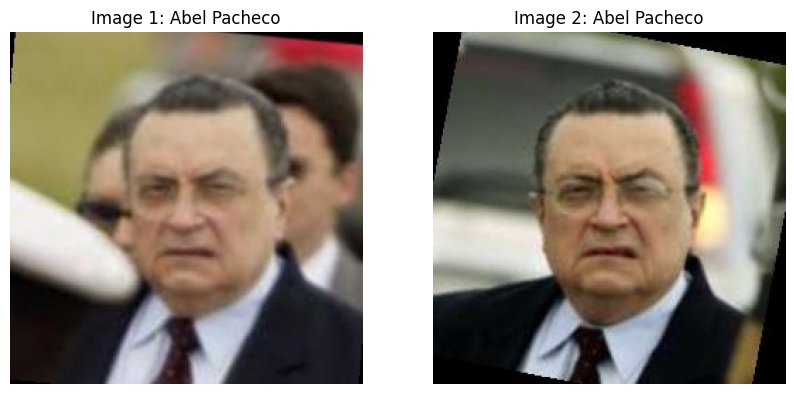

In [14]:
img1 = imread(image_path1)
img2 = imread(image_path2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#first
axes[0].imshow(img1)
axes[0].set_title('Image 1: Abel Pacheco')
axes[0].axis('off')

#second 
axes[1].imshow(img2)
axes[1].set_title('Image 2: Abel Pacheco')
axes[1].axis('off')

plt.show()

Cosine Similarity: -0.08977325
Similarity Percentage: 0.00%


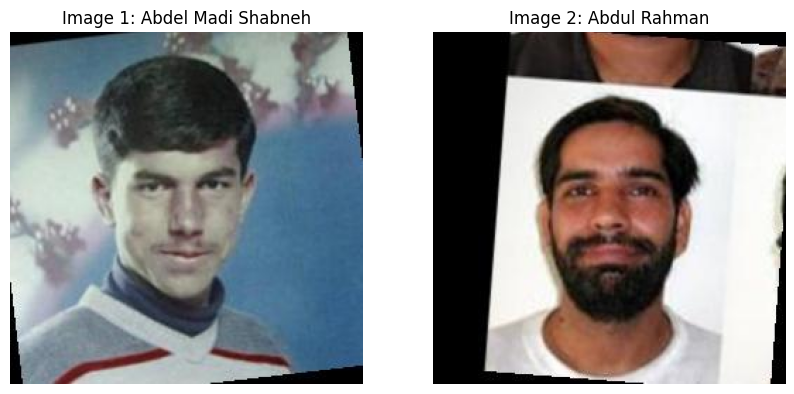

In [13]:
# trying out the Model with different people
if __name__ == "__main__":
    
    preprocessing_pipeline = PreprocessingPipeline(target_size=(224, 224))
    feature_extraction_pipeline = FeatureExtractionPipeline(device='cpu')
    # paths of two images for comparison
    image_path3 = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg"
    image_path4 = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Abdul_Rahman/Abdul_Rahman_0001.jpg"

    try:
        preprocessed_img3 = preprocessing_pipeline.preprocess(image_path3)
        preprocessed_img4 = preprocessing_pipeline.preprocess(image_path4)

        features3 = feature_extraction_pipeline.extract_features(preprocessed_img3)
        features4 = feature_extraction_pipeline.extract_features(preprocessed_img4)

        cosine_sim = calculate_cosine_similarity(features3, features4)
        similarity_percentage = convert_cosine_similarity_to_percentage(cosine_sim)

        print("Cosine Similarity:", cosine_sim)
        print("Similarity Percentage: {:.2f}%".format(similarity_percentage))

    except Exception as e:
        print("Error during similarity calculation:", e)

# plotting
img1 = imread(image_path3)
img2 = imread(image_path4)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#first
axes[0].imshow(img1)
axes[0].set_title('Image 1: Abdel Madi Shabneh')
axes[0].axis('off')

#second 
axes[1].imshow(img2)
axes[1].set_title('Image 2: Abdul Rahman')
axes[1].axis('off')

plt.show()

<a id="1"></a>
# <p style="background-color:#000000;font-family:georgia,serif;color:#FFF8ED;font-size:140%;text-align:center;border-radius:10px 10px;">Thank You</p>